<a href="https://colab.research.google.com/github/Awaish0419/OptionPricing/blob/main/optionPricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation function of Vanilla options

## Explicit method

In [236]:
def calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S):
  delta_t = T / M
  delta_S = max_S / N

  import math

  values = [[0] * (M + 1) for _ in range(N + 1)]

  #　initial all edges.
  if isCall:
    # when t = T
    for i in range(N + 1):
      intrinsic_value = i * delta_S - K
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = 0

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = max_S

  if (not isCall):
    # when t = T
    for i in range(N + 1):
      intrinsic_value = K - i * delta_S
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = K * math.exp(-r * (T - i * delta_t))

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = 0

  # Algorithm
  for m in range(M - 1, -1, -1):
    for n in range(1, N, 1):
      p = (sigma * n) ** 2
      q = r * n
      d = 1 / 2 * delta_t * (p - q)
      l = 1 - r * delta_t - p * delta_t
      u = 1 / 2 * delta_t * (p + q)
      value = values[n-1][m+1] * d + values[n][m+1] * l + values[n+1][m+1] * u
      values[n][m] = value
      if (not isEuropean):  # American option
        this_intrinsic_value = 0
        if isCall:
          this_intrinsic_value = n * delta_S - K
        if (not isCall):
          this_intrinsic_value = K - n * delta_S
        if (value < this_intrinsic_value):
          values[n][m] = this_intrinsic_value

  prices = [0] * (N + 1)
  for n in range(N + 1):
    prices[n] = values[n][0]

  return prices

## Implicit method

In [237]:
def calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S):
  import math
  import numpy as np

  delta_t = T / M
  delta_S = max_S / N

  values = [[0] * (M + 1) for _ in range(N + 1)]

  #　initial all edges.
  if isCall:
    # when t = T
    for i in range(N + 1):
      intrinsic_value = i * delta_S - K
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = 0

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = max_S

  if (not isCall):
    # when t = T
    for i in range(N + 1):
      intrinsic_value = K - i * delta_S
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = K * math.exp(-r * (T - i * delta_t))

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = 0

  # Algorithm
  A = np.zeros((N-1, N-1))
  b = np.zeros((N-1))
  alpha = sigma**2 * delta_t
  beta = r * delta_t
  for m in range(M-1, -1, -1):
    # set b vector
    for i in range(N - 1):
      b[i] = values[i+1][m+1]
    b[0] -= (beta - alpha) / 2 * values[0][m]
    b[N-2] += (beta * (N-1) + (alpha * (N-1)**2)) / 2 * values[N][m]

    # set A matrix
    for n in range(N-1):
      if (n == 0):
        A[0, 0] = 1 + beta + alpha
        A[0, 1] = (- beta - alpha) / 2
      elif (n == N - 2):
        A[N-2, N-3] = (beta * (n + 1) - alpha * (n + 1) ** 2) / 2
        A[N-2, N-2] = 1 + beta + alpha * (n + 1) ** 2
      else:
        A[n, n-1] = (beta * (n + 1) - alpha * (n + 1) ** 2) / 2
        A[n, n] = 1 + beta + alpha * (n + 1) ** 2
        A[n, n+1] = (- beta * (n + 1) - alpha * (n + 1) ** 2) / 2

    # solve A * V(m) = V(m + 1) (Ax = b)
    x = np.linalg.solve(A, b)

    # copy solution to values matrix
    for n in range(N - 1):
      values[n+1][m] = x[n]
      if (not isEuropean):
        this_intrinsic_value = 0
        if isCall:
          this_intrinsic_value = (n + 1) * delta_S - K
        if (not isCall):
          this_intrinsic_value = K - (n + 1) * delta_S
        if (x[n] < this_intrinsic_value):
          values[n+1][m] = this_intrinsic_value

  prices = [0] * (N + 1)
  for n in range(N + 1):
    prices[n] = values[n][0]

  return prices


## Crank-Nicolson (semi-implicit method)

In [238]:
def calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S):
  import math
  import numpy as np

  delta_t = T / M
  delta_S = max_S / N

  values = [[0] * (M + 1) for _ in range(N + 1)]

  #　initial all edges.
  if isCall:
    # when t = T
    for i in range(N + 1):
      intrinsic_value = i * delta_S - K
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = 0

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = max_S

  if (not isCall):
    # when t = T
    for i in range(N + 1):
      intrinsic_value = K - i * delta_S
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = K * math.exp(-r * (T - i * delta_t))

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = 0

  # Algorithm
  A = np.zeros((N-1, N-1))
  b = np.zeros((N-1))
  alpha = sigma**2 * delta_t
  beta = r * delta_t
  for m in range(M-1, -1, -1):
    # set b vector
    for i in range(N - 1):
      b[i] = values[i+1][m+1]
    b[0] += alpha / 2 * values[0][m]
    b[N-2] += (beta * (N-1) + (alpha * (N-1)**2) / 2) * values[N][m]

    # set A matrix
    for n in range(N-1):
      if (n == 0):
        A[0, 0] = 1 + beta + beta + alpha
        A[0, 1] = - beta - alpha / 2
      elif (n == N - 2):
        A[N-2, N-3] = - alpha * (n + 1) ** 2 / 2
        A[N-2, N-2] = 1 + beta + beta * (n + 1) + alpha * (n + 1) ** 2
      else:
        A[n, n-1] = - alpha * (n + 1) ** 2 / 2
        A[n, n] = 1 + beta + beta * (n + 1) + alpha * (n + 1) ** 2
        A[n, n+1] = - beta * (n + 1) - alpha * (n + 1) ** 2 / 2

    # solve A * V(m) = V(m + 1) (Ax = b)
    x = np.linalg.solve(A, b)

    # copy solution to values matrix
    for n in range(N - 1):
      values[n+1][m] = x[n]
      if (not isEuropean):
        this_intrinsic_value = 0
        if isCall:
          this_intrinsic_value = (n + 1) * delta_S - K
        if (not isCall):
          this_intrinsic_value = K - (n + 1) * delta_S
        if (x[n] < this_intrinsic_value):
          values[n+1][m] = this_intrinsic_value

  prices = [0] * (N + 1)
  for n in range(N + 1):
    prices[n] = values[n][0]

  return prices


## Visualize the results.

In [239]:
import matplotlib.pyplot as plt

### Explicit method

#### European call option.

In [240]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = True
# max S
max_S = 3 * K

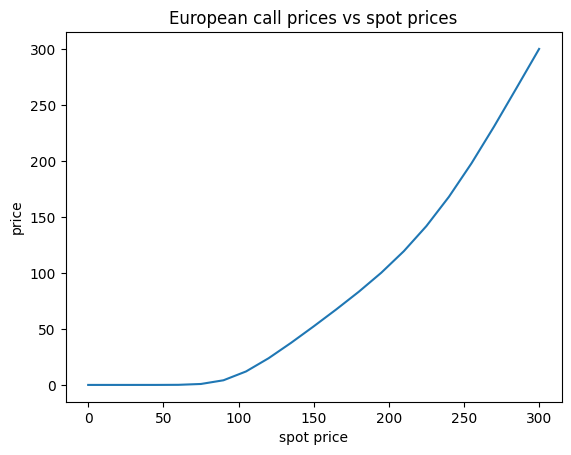

In [241]:
European_call_prices = calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_call_prices)

plt.title('European call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### European put option

In [242]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = False
# max S
max_S = 3 * K

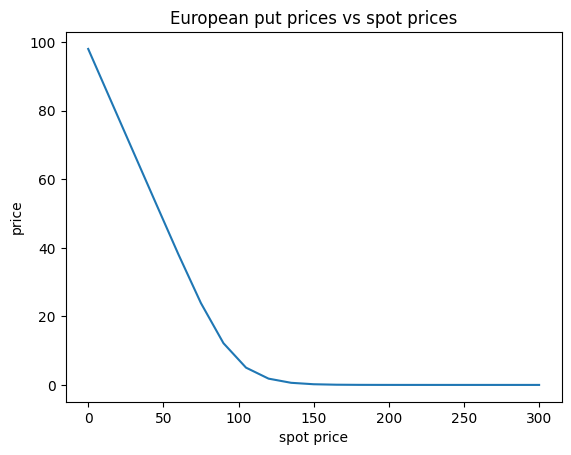

In [243]:
European_put_prices = calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_put_prices)

plt.title('European put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American call option

In [244]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = True
# max S
max_S = 3 * K

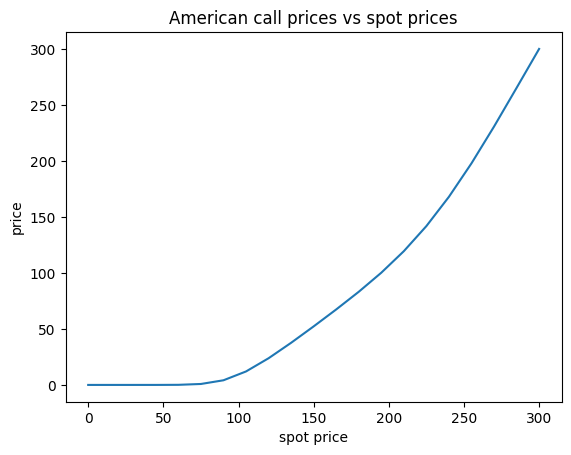

In [245]:
American_call_prices = calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_call_prices)

plt.title('American call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American put option

In [246]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = False
# max S
max_S = 3 * K

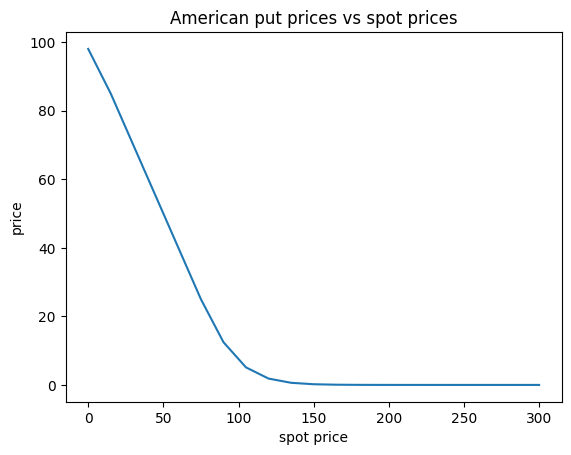

In [247]:
American_put_prices = calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_put_prices)

plt.title('American put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

### Implicit method

#### European call option.

In [248]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = True
# max S
max_S = 3 * K

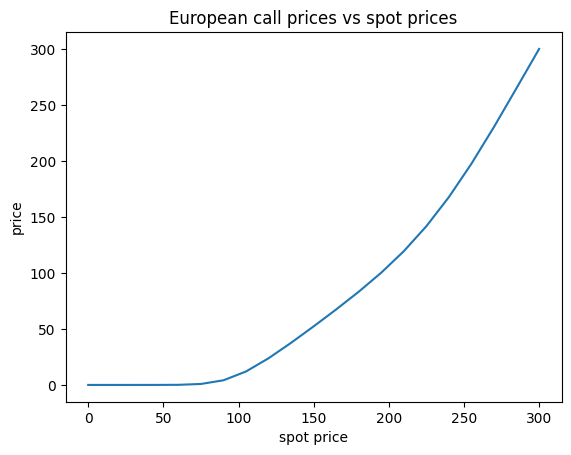

In [249]:
European_call_prices = calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_call_prices)

plt.title('European call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### European put option

In [250]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = False
# max S
max_S = 3 * K

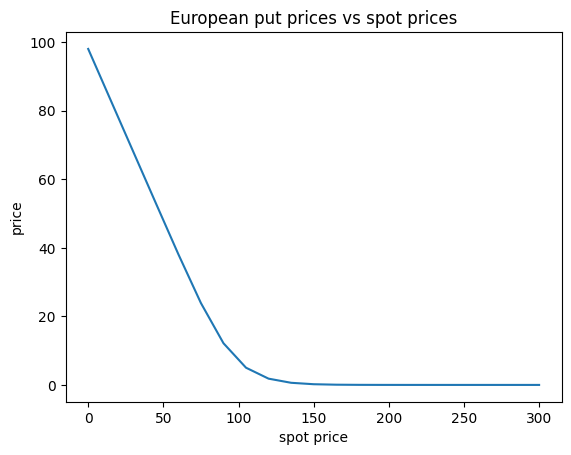

In [251]:
European_put_prices = calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_put_prices)

plt.title('European put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American call option

In [252]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = True
# max S
max_S = 3 * K

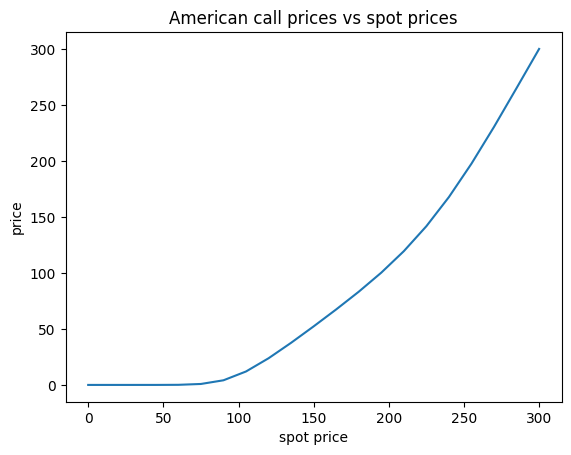

In [253]:
American_call_prices = calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_call_prices)

plt.title('American call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American put option

In [254]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = False
# max S
max_S = 3 * K

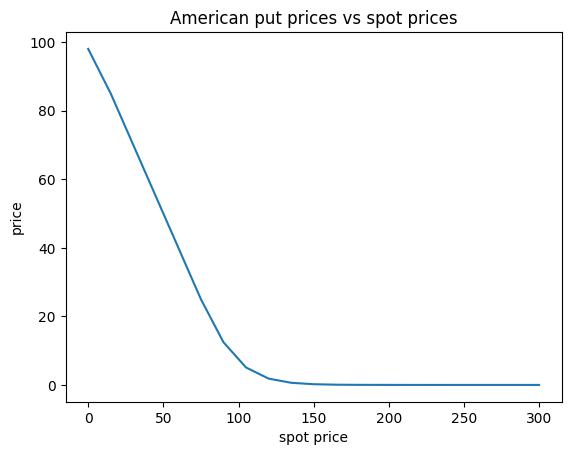

In [255]:
American_put_prices = calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_put_prices)

plt.title('American put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

### Crank-Nicolson (semi-implicit method)

#### European call option.

In [256]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = True
# max S
max_S = 3 * K

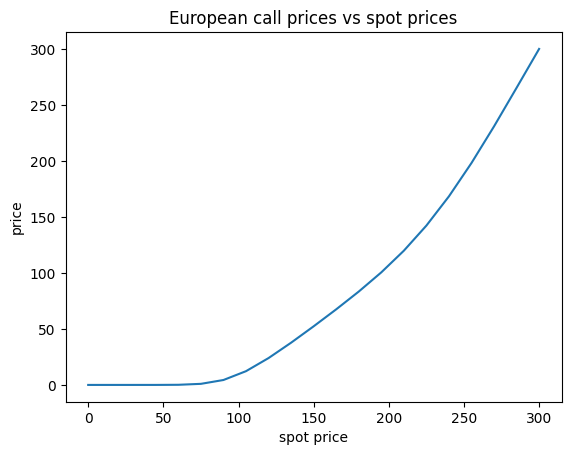

In [257]:
European_call_prices = calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_call_prices)

plt.title('European call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### European put option

In [258]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = False
# max S
max_S = 3 * K

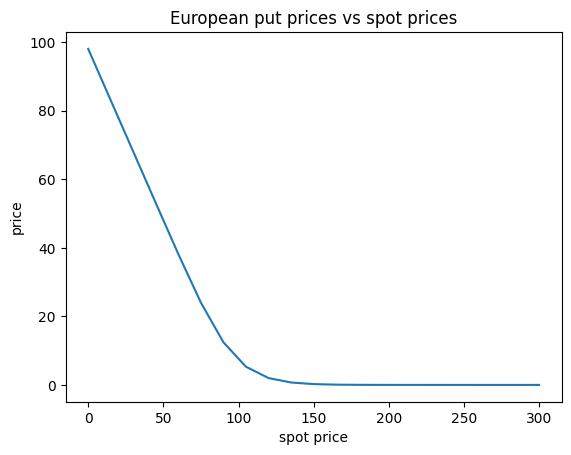

In [259]:
European_put_prices = calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_put_prices)

plt.title('European put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American call option

In [260]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = True
# max S
max_S = 3 * K

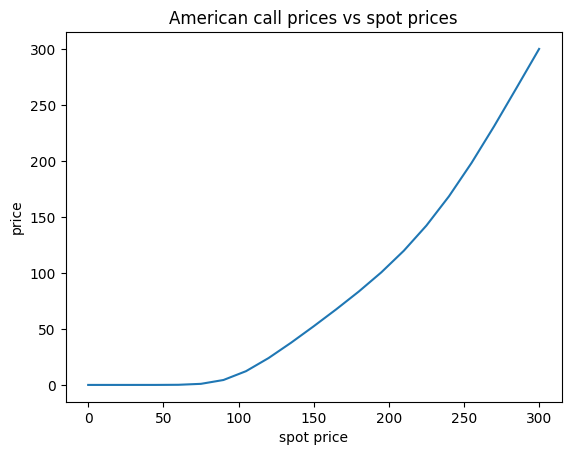

In [261]:
American_call_prices = calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_call_prices)

plt.title('American call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American put option

In [262]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = False
# max S
max_S = 3 * K

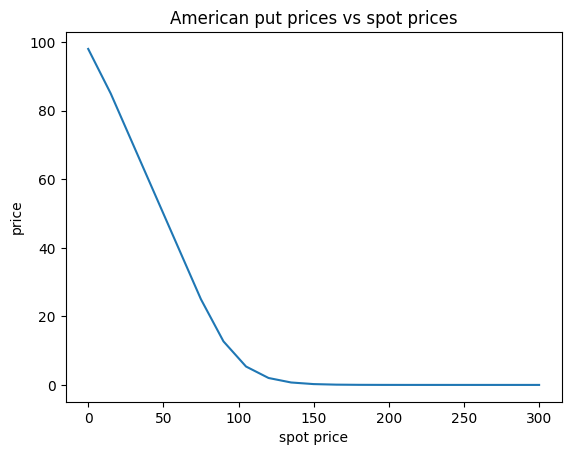

In [263]:
American_put_prices = calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_put_prices)

plt.title('American put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

# Evaluation function of Asian option

## Monte Carlo

In [274]:
def calculate_asian_value_monte_carlo(S0, T, r, sigma, K, num_time_steps, num_paths, isCall, averaging="arithmetic"):
  import numpy as np

  dt = T / num_time_steps
  discount_factor = np.exp(-r * T)

  S = np.zeros((num_paths, num_time_steps + 1))
  S[:, 0] = S0

  for t in range(1, num_time_steps + 1):
    Z = np.random.standard_normal(num_paths)
    S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

  if averaging == "arithmetic":
    S_avg = np.mean(S[:, 1:], axis=1)
  elif averaging == "geometric":
    S_avg = np.exp(np.mean(np.log(S[:, 1:]), axis=1))

  if isCall:
    payoffs = np.maximum(S_avg - K, 0)
  elif (not isCall):
    payoffs = np.maximum(K - S_avg, 0)

  option_price = discount_factor * np.mean(payoffs)

  return option_price

## Finite Difference PDE (one dimension)

## Visualize the results

In [275]:
import matplotlib.pyplot as plt
import numpy as np

### Monte Carlo

#### Call option with arithmetic averaging

In [276]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# divide T into num_time_steps steps
num_time_steps = 100
# number of manipulation
num_paths = 10000
# Call or Put option
isCall = True
# averaging (arithmetic or geometric)
averaging = "arithmetic"

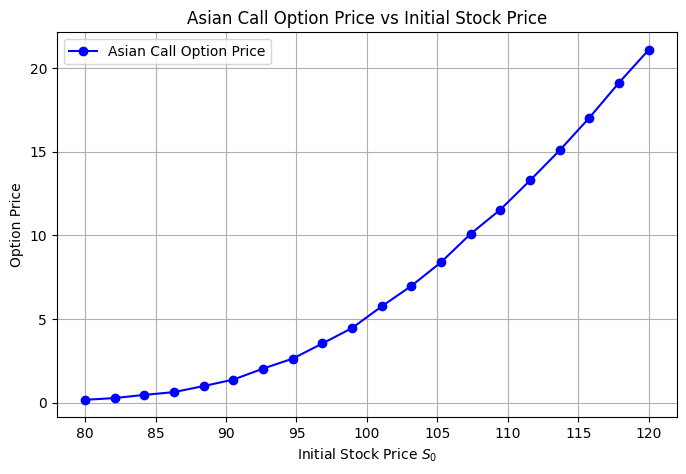

In [277]:
S0_values = np.linspace(80, 120, 20)
option_prices = [calculate_asian_value_monte_carlo(S0, T, r, sigma, K, num_time_steps, num_paths, isCall, averaging) for S0 in S0_values]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(S0_values, option_prices, marker='o', linestyle='-', color='b', label="Asian Call Option Price")
plt.xlabel("Initial Stock Price $S_0$")
plt.ylabel("Option Price")
plt.title("Asian Call Option Price vs Initial Stock Price")
plt.legend()
plt.grid(True)
plt.show()

#### Call option with geometric averaging

In [278]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# divide T into num_time_steps steps
num_time_steps = 100
# number of manipulation
num_paths = 10000
# Call or Put option
isCall = True
# averaging (arithmetic or geometric)
averaging = "geometric"

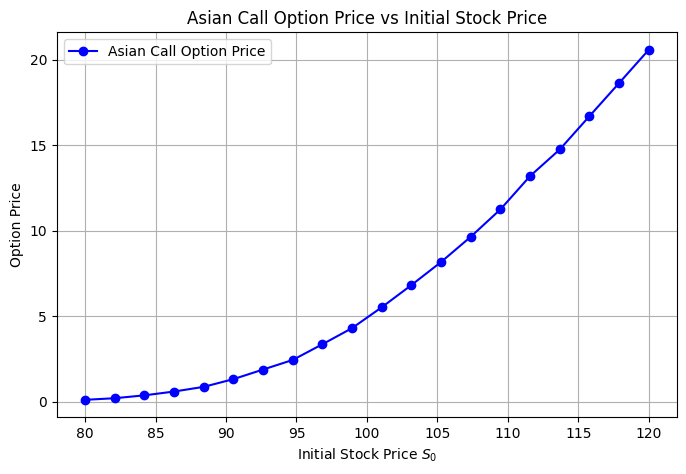

In [279]:
S0_values = np.linspace(80, 120, 20)
option_prices = [calculate_asian_value_monte_carlo(S0, T, r, sigma, K, num_time_steps, num_paths, isCall, averaging) for S0 in S0_values]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(S0_values, option_prices, marker='o', linestyle='-', color='b', label="Asian Call Option Price")
plt.xlabel("Initial Stock Price $S_0$")
plt.ylabel("Option Price")
plt.title("Asian Call Option Price vs Initial Stock Price")
plt.legend()
plt.grid(True)
plt.show()

#### Put option with arithmetic averaging

In [280]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# divide T into num_time_steps steps
num_time_steps = 100
# number of manipulation
num_paths = 10000
# Call or Put option
isCall = False
# averaging (arithmetic or geometric)
averaging = "arithmetic"

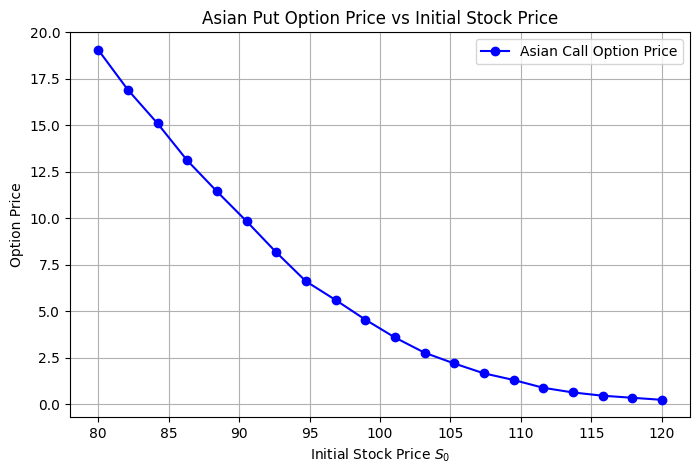

In [281]:
S0_values = np.linspace(80, 120, 20)
option_prices = [calculate_asian_value_monte_carlo(S0, T, r, sigma, K, num_time_steps, num_paths, isCall, averaging) for S0 in S0_values]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(S0_values, option_prices, marker='o', linestyle='-', color='b', label="Asian Call Option Price")
plt.xlabel("Initial Stock Price $S_0$")
plt.ylabel("Option Price")
plt.title("Asian Put Option Price vs Initial Stock Price")
plt.legend()
plt.grid(True)
plt.show()

#### Put option with geometric averaging

In [282]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# divide T into num_time_steps steps
num_time_steps = 100
# number of manipulation
num_paths = 10000
# Call or Put option
isCall = False
# averaging (arithmetic or geometric)
averaging = "geometric"

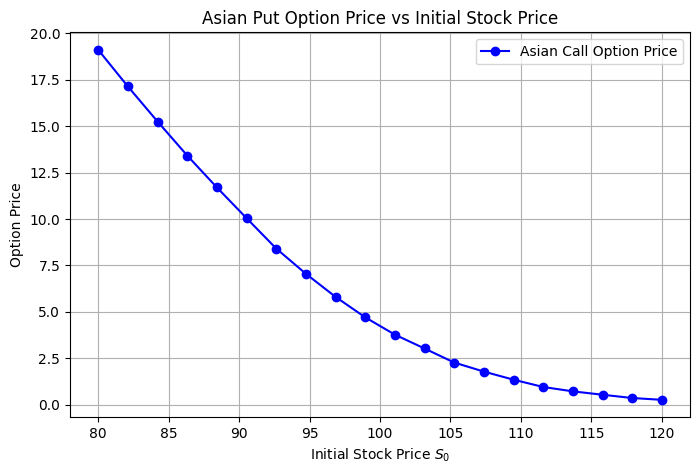

In [283]:
S0_values = np.linspace(80, 120, 20)
option_prices = [calculate_asian_value_monte_carlo(S0, T, r, sigma, K, num_time_steps, num_paths, isCall, averaging) for S0 in S0_values]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(S0_values, option_prices, marker='o', linestyle='-', color='b', label="Asian Call Option Price")
plt.xlabel("Initial Stock Price $S_0$")
plt.ylabel("Option Price")
plt.title("Asian Put Option Price vs Initial Stock Price")
plt.legend()
plt.grid(True)
plt.show()

### Finite Difference PDE (1 dimension)

### Finite Differnce PDE (2 dimension)

### Moment Matching